In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import os

In [16]:
directory_path = "../experiment/"

# Get all CSV file names in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    dataframe = pd.read_csv(file_path)
    dataframes.append(dataframe)
df = pd.concat(dataframes, ignore_index=True)
df


,Method,Planner,Map ID,Number of agents,Number of pillars,Agent speed,Drone speed,Depth variance,Flight time,Grid discovered,Agent tracked,Agent tracked time,Success,Static Collision,Dynamic Collision,Freezing,Dead Lock
0,LookAhead,Primitive,30,10,10,20,20,5,38.2,747,3,9.366667,1,0,0,0,0
1,LookAhead,Primitive,31,10,10,20,20,5,40.4,745,5,9.240000,1,0,0,0,0
2,LookAhead,Primitive,32,10,10,20,20,5,12.6,271,1,0.600000,0,0,1,0,0
3,LookAhead,Primitive,33,10,10,20,20,5,35.0,678,3,8.300000,1,0,0,0,0
4,LookAhead,Primitive,34,10,10,20,20,5,38.0,706,4,8.200000,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,Owl,Jerk_Primitive,55,30,10,60,40,5,15.0,670,2,4.200000,1,0,0,0,0
12956,Owl,Jerk_Primitive,56,30,10,60,40,5,0.6,83,3,0.466667,0,0,1,0,0
12957,Owl,Jerk_Primitive,57,30,10,60,40,5,5.4,276,5,3.140000,0,0,1,0,0
12958,Owl,Jerk_Primitive,58,30,10,60,40,5,5.0,274,3,2.300000,0,0,1,0,0


In [17]:
gaze_methods = ['NoControl', 'LookAhead', 'Owl']
planners = ['Jerk_Primitive', 'MPC', 'Primitive']
agent_numbers = [10, 20, 30]
pillar_numbers = [0, 5, 10]
agent_max_speeds = [20, 40, 60]
drone_max_speeds = [20, 40]
depth_vars = [5]

In [18]:
result_df = pd.DataFrame([], columns=['Method', 
                                      'Planner', 
                                      'Number of agents', 
                                      'Number of pillars', 
                                      'Agent speed', 
                                      'Drone speed',
                                      'Depth variance',
                                      'Total samples',
                                      'Success',
                                      'Static Collision',
                                      'Dynamic Collision',
                                      'Dead Lock',
                                      'Success rate'])
for gaze_method in gaze_methods:
    for agent_number in agent_numbers:
        for pillar_number in pillar_numbers:
            for agent_speed in agent_max_speeds:
                for drone_speed in drone_max_speeds:
                    for planner in planners:
                        for depth_var in depth_vars:
                            df_i = df[(df['Method'] == gaze_method) &
                                    (df['Planner'] == planner) &
                                    (df['Number of agents']==agent_number) & 
                                    (df['Number of pillars']==pillar_number) &
                                    (df['Agent speed']==agent_speed) &
                                    (df['Drone speed']==drone_speed) &
                                    (df['Depth variance']==depth_var)].copy(deep=True)
                            if df_i.shape[0] != 0:
                                result_df.loc[len(result_df)] = [
                                    gaze_method,
                                    planner,
                                    agent_number,
                                    pillar_number,
                                    agent_speed,
                                    drone_speed,
                                    depth_var,
                                    df_i.shape[0], #total samples
                                    df_i['Success'].sum(),
                                    df_i['Static Collision'].sum(),
                                    df_i['Dynamic Collision'].sum(),
                                    df_i['Dead Lock'].sum(),
                                    (df_i['Success'].sum() + df_i['Dead Lock'].sum()) / df_i.shape[0] # Success rate
                                    # df_i['Success'].sum(),#total success
                                    # df_i['Static Collision'].sum(),
                                    # df_i['Dynamic Collision'].sum(),
                                    # df_i['Grid discovered'].sum() / df_i['Steps'].sum(),
                                    # 100 * df_i['Agent tracked'].sum() / df_i['Steps'].sum(),
                                    # df_i['Total track time'].sum() / (df_i['Agent tracked']).sum()
                                ]


In [19]:

# result_df['Success rate'] = result_df['Success'] / result_df['Total samples']
result_df['velocity ratio'] = result_df['Agent speed'] / result_df['Drone speed']
result_df.to_csv('./post.csv')                            

/tmp/ipykernel_11357/1606150789.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_single = df[result_df[x_label] == x_value]


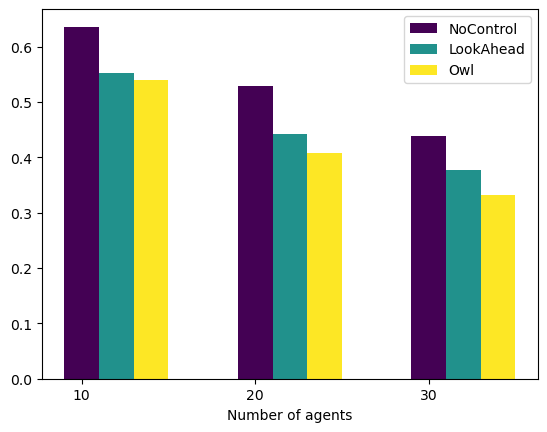

In [20]:
import matplotlib as mpl
fig, ax = plt.subplots()
width = 0.2
x_label = 'Number of agents'
legend = 'Method'

x_values = (result_df[x_label].unique())
x_values.sort()
labels = result_df[legend].unique()

cmap = mpl.cm.get_cmap("viridis", len(labels))
colors = cmap(np.linspace(0, 1, len(labels)))

for i, label in enumerate(labels):
    
    df = result_df[result_df[legend] == label]
    y_values = []
    rects = []

    for x_value in x_values:
        df_single = df[result_df[x_label] == x_value]
        y_values.append(1 - df_single['Dynamic Collision'].sum() / df_single['Total samples'].sum())
    
    rects.append(ax.bar(np.arange(len(x_values)) + i*width, y_values, width, color=colors[i], label=label))

plt.xticks(range(x_values.shape[0]), x_values)
plt.xlabel(x_label)
plt.legend()    
plt.show()

/tmp/ipykernel_11357/2702474690.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_single = df[result_df[x_label] == x_value]


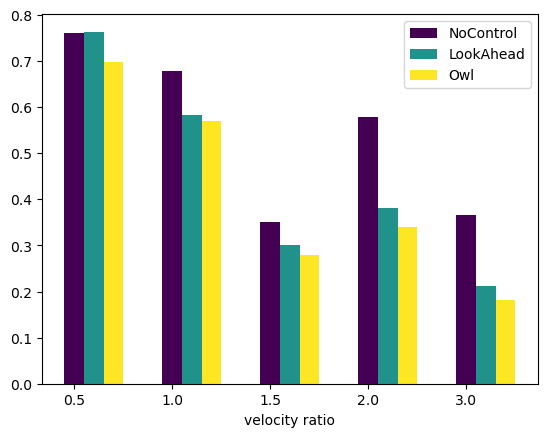

In [21]:
import matplotlib as mpl
fig, ax = plt.subplots()
width = 0.2
x_label = 'velocity ratio'
legend = 'Method'

x_values = (result_df[x_label].unique())
x_values.sort()
labels = result_df[legend].unique()

cmap = mpl.cm.get_cmap("viridis", len(labels))
colors = cmap(np.linspace(0, 1, len(labels)))

for i, label in enumerate(labels):
    
    df = result_df[result_df[legend] == label]
    y_values = []
    rects = []

    for x_value in x_values:
        df_single = df[result_df[x_label] == x_value]
        y_values.append((df_single['Success'].sum() + df_single['Dead Lock'].sum()) / df_single['Total samples'].sum())
    
    rects.append(ax.bar(np.arange(len(x_values)) + i*width, y_values, width, color=colors[i], label=label))

plt.xticks(range(x_values.shape[0]), x_values)
plt.xlabel(x_label)
plt.legend()    
plt.show()